# Quickstart

General rundown of the API for loading data and training a model.

https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## Working with data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

test_data first entry: (data, label):
    sizes: img: torch.Size([1, 28, 28]) label: 9
    types: img: <class 'torch.Tensor'> label: <class 'int'>
    img_squeezed: torch.Size([28, 28])


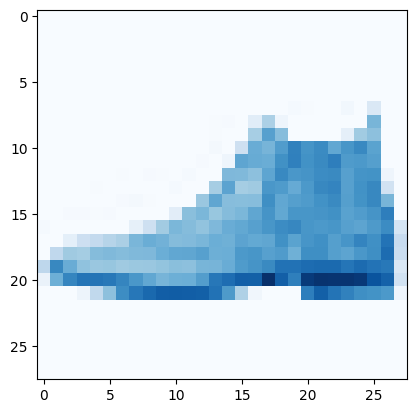

In [1]:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL

DEBUG = False

# Download training data
# We are using the FashionMNIST dataset: https://github.com/zalandoresearch/fashion-mnist
# This is a dataset of 28x28 grayscale images that are each associated with a label from 10 classes
training_data = datasets.FashionMNIST(
    root="data",
    train=True,  # Specify true to get the training data
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
# The FashionMNIST dataset is a dataset of
# labelled images of clothing/shoes.
#
# Each datapoint is a PIL.Image
test_data = datasets.FashionMNIST(
    root="data",
    train=False,  # Specify false to get the test data
    download=True,
    transform=ToTensor(), # Converts the PIL.Image datapoints into Tensors.
)

display(training_data)
display(test_data)

print(f"test_data first entry: (data, label):")
data: tuple[torch.Tensor, torch.Tensor] = test_data[0]
img, label = data
# Each image is in the format (C, H, W)
# C = number of channels. It's 1 for all FashionMNIST datapoints, since they are all grayscale images
# H = height of each image
# W = width of each image
print(f"    sizes: img: {img.shape} label: {label}")
print(f"    types: img: {type(img)} label: {type(label)}")
img_squeezed = img.squeeze()
# We use squeeze to remove the from channel dimension, since we
# need to feed a 2D matrix into plt's imshow 
print(f"    img_squeezed: {img_squeezed.shape}")
plt.imshow(img_squeezed, cmap="Blues")

In [2]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# We cannot fetch an index of a dataloader, since it's an iterator
# Therefore we have to iterate over it instead to access each element
for X, y in test_dataloader:
    # Since each image was (C, H< W), batching it adds another dimension N
    # to the start, which represents the number of examples per batch
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    # Y is now a tensor of size N, which represents the labels associated
    # with each example
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Since the input is a 2D matrix, we have to flatten it into a 1D vector
        # that we can then feed into the neural network
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # Since the input is a 2D matrix, we have to flatten it into a 1D vector
        # that we can then feed into the neural network
        x = self.flatten(x)
        # In ML, logits is a another name for the raw (non-normalized) predictions
        # that a classification model generates.
        #  
        # https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173
        # https://developers.google.com/machine-learning/glossary/#logits
        logits = self.linear_relu_stack(x)  
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
# Cross entropy loss (AKA Log-likelihood loss)
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
# We use the loss function like
#   loss_fn(logits, ground_truth)
# This applies softmax to the logits (normalizing the logits), and then applies log-likelihood
loss_fn = nn.CrossEntropyLoss()
# Optimizer = How we calculate the gradient
#   SGD = Stochastic gradient descent
#       We estimate the gradient of the entire dataset by sampling 
#       a fixed number of points and identifying the gradient from the points.
# lr = Learning rate
# There are also different ways of calculating gradient to address osciliation issues, plataeus, etc.
#   See Adagrad, RMSProp, etc.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Optimizing Model Parameters

In [5]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    model.train() # Configure model for training, which tells dropout layers to perform dropout
    # Iterate over the batches
    #
    # The dataloader loads a dataset and splits it into batches so we
    # can perform stochastic gradient descent. It returns
    # an iterator over the batches.
    for batch, (X, y) in enumerate(dataloader):
        # Move the X and Y tensors to the device we're running the model on
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) # Returns a tensor that contains the predictions from our model
        loss = loss_fn(pred, y)

        # Perform backpropagation from the loss function
        loss.backward()
        optimizer.step() # Updates the parameters
        # Reset the accumulated gradient after we're done calculating the gradients. 
        # Remember, in backpropagation we accrue gradient values, which is important 
        # for RNNs that repeatedly feed into itself.
        optimizer.zero_grad() 

        # Print the loss every once in a while so we can track how our training is doing
        if batch % 100 == 0:
            # batch = current batch number
            # len(X) = number of samples per batch (This is fixed across al batches)
            # 
            # By multiplying batch size by total 
            _loss, current = loss.item(), (batch + 1) * len(X)
            # NOTE: The loss is a scalar value (regular number)
            # Scalars in pytorch are represented as tensors of size torch.size([]), which are zero dimensional
            # 
            # .item() extracts the scalar value from the zero dimensional tensor
            print(f"loss: {loss.shape} {loss} _loss: {_loss:>7f}  [{current:>5d}/{size:>5d}]")
            if DEBUG:
                print(f"types: pred: {pred[:3]} y: {y[:3]} loss: {loss}")

# train(train_dataloader, model, loss_fn, optimizer)

In [6]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Sets module to evaluation mode, which is important for telling dropout layers to stop dropping out
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disables autograd engine
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred: torch.Tensor = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches # Calculate average test_loss across all batches
    correct /= size # Calculate correct %
    print(f"Test error: \n Accuracy: {(100 * correct):>0.1f}% Avg loss: {test_loss:>8f} \n")

# test(test_dataloader, model, loss_fn)

In [7]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: torch.Size([]) 2.3049347400665283 _loss: 2.304935  [   64/60000]
loss: torch.Size([]) 2.2955398559570312 _loss: 2.295540  [ 6464/60000]
loss: torch.Size([]) 2.2732653617858887 _loss: 2.273265  [12864/60000]
loss: torch.Size([]) 2.269732713699341 _loss: 2.269733  [19264/60000]
loss: torch.Size([]) 2.2397804260253906 _loss: 2.239780  [25664/60000]
loss: torch.Size([]) 2.2150111198425293 _loss: 2.215011  [32064/60000]
loss: torch.Size([]) 2.2194411754608154 _loss: 2.219441  [38464/60000]
loss: torch.Size([]) 2.183429479598999 _loss: 2.183429  [44864/60000]
loss: torch.Size([]) 2.1880457401275635 _loss: 2.188046  [51264/60000]
loss: torch.Size([]) 2.1558046340942383 _loss: 2.155805  [57664/60000]
Test error: 
 Accuracy: 45.0% Avg loss: 2.149861 

Epoch 2
-------------------------------
loss: torch.Size([]) 2.1584279537200928 _loss: 2.158428  [   64/60000]
loss: torch.Size([]) 2.150747060775757 _loss: 2.150747  [ 6464/60000]
loss: torch.Size([])

## Saving + Loading Models

In [9]:
# Save our model's internal state (which is a python dictionary), into a file
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
# Loading a model from a file
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [20]:
# Using our new model to make predictions
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
# Evaluate first 10 test datapoints
for i in range(10):
    x, y = test_data[i]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Pullover", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Coat", Actual: "Coat"
Predicted: "Coat", Actual: "Shirt"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"
